In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from my_functions import filter_columns_from_data_source

pd.set_option('display.max_columns', None)
# read the data from https://pslcdatashop.web.cmu.edu/DatasetInfo?datasetId=579 
# 
# 
#df_data=pd.read_csv("survey_results_public.csv")
my_selected_columns=[ 
    "MainBranch", # classification of developer (profession-hobby)
    "Age", # categorized under 18,  18-24, 25-34 35-44 45-54 55-64 65 and above no comment
    "Employment", # categorized 
    "EdLevel", # categorized primary, secondary, college / university without degree, Associated ,Bachelor , Master , professional degree , else  / 
    "LearnCode", 
    "YearsCode",
    "YearsCodePro",
    "WorkExp",
    "DevType",
    "OrgSize",
    "AISelect", # categrical use AI in current workflow Yes, NO, but I plan to soon No, and I don not plan to  
    "AISent", # categorical from favourablevery  to indifferent to very unfavourable and unsure
    "AIAcc",  # Likert like Highly , somewhat neiter trust nor distrust somewhat distrust, highly distrust
    "AIComplex",
    "AIThreat", # thread to job, yes, no I am not sure
    "ConvertedCompYearly", # numerical 
    "JobSat"  # numerical categorized 
#my_selected_columns=[ 
#    "Age",
#    "EdLevel",
#    "YearsCode",
#    "WorkExp",
#    "AISearchDevHaveWorkedWith",
#    "AISearchDevWantToWorkWith",
#    "AISelect",
#    "JobSat"
]

# removed     "YearsCodePro","ConvertedCompYearly",    "AISent", "AIAcc",

# due to the large number of questions (columns) and sometimes large number of string reply options (categories) per question 
# a preselection has been made.
df_filtered=filter_columns_from_data_source(my_selected_columns,"survey_results_public.csv")
df_schema=pd.read_csv("survey_results_schema.csv")


df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MainBranch           65437 non-null  object 
 1   Age                  65437 non-null  object 
 2   Employment           65437 non-null  object 
 3   EdLevel              60784 non-null  object 
 4   LearnCode            60488 non-null  object 
 5   YearsCode            59869 non-null  object 
 6   YearsCodePro         51610 non-null  object 
 7   WorkExp              29658 non-null  float64
 8   DevType              59445 non-null  object 
 9   OrgSize              47480 non-null  object 
 10  AISelect             60907 non-null  object 
 11  AISent               45873 non-null  object 
 12  AIAcc                37302 non-null  object 
 13  AIComplex            37021 non-null  object 
 14  AIThreat             44689 non-null  object 
 15  ConvertedCompYearly  23435 non-null 

In [2]:
# Question: can we deduce the best starting conditions in terms of competence, experience, job, company size for data science
# The target is the usage , the planned or the denied usage of AI tools : column AISelect

# try to remove all nan first from the list
df_clean=df_filtered.dropna(how="any")

# check that there are enough variations in the target column AISelect, i.e. all three categories are still present
print(df_clean["AISelect"].unique())


['Yes']


In [3]:
# Oops removing all rows containing a nan leads to an option loss in the target function. 
# Alternative approach: identify a selection from current columns that leaves at least all categories in
df_red_filtered_1=df_filtered.drop(["LearnCode","WorkExp","DevType","AIComplex","AIThreat","ConvertedCompYearly","AIAcc","AISent","JobSat"],axis=1)
df_clean_1=df_red_filtered_1.dropna(how="any")
print(df_clean_1["AISelect"].unique())
df_clean_1.info()

['Yes' "No, and I don't plan to" 'No, but I plan to soon']
<class 'pandas.core.frame.DataFrame'>
Index: 45976 entries, 72 to 65435
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MainBranch    45976 non-null  object
 1   Age           45976 non-null  object
 2   Employment    45976 non-null  object
 3   EdLevel       45976 non-null  object
 4   YearsCode     45976 non-null  object
 5   YearsCodePro  45976 non-null  object
 6   OrgSize       45976 non-null  object
 7   AISelect      45976 non-null  object
dtypes: object(8)
memory usage: 3.2+ MB


In [4]:
# After some trial and error removing AIAcc Next step is to categorize the strings and remove a reference column. 
# Approach is to chose the category with an average number of occurrences 
label_encoder=LabelEncoder()
y_encoded=label_encoder.fit_transform(df_clean_1["AISelect"])

df_X=df_clean_1.drop(["AISelect"],axis=1)
cat_columns=df_X.select_dtypes(include=["object","category"]).columns
# not needed because removed: num_columns=df_clean_ext.select_dtypes(include=["int64","float64"]).columns
# separate x and y
current_encoder=OneHotEncoder(drop="first", sparse_output=False)
X_encoded=current_encoder.fit_transform(df_X)
  



In [5]:
# to identfy the most important features 
# create train and test data set
X_train,X_test,y_train,y_test=train_test_split(X_encoded,y_encoded,test_size=0.2,random_state=42)



In [6]:
# train model
model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
    

RandomForestClassifier(random_state=42)

In [7]:
# analyse feature list
# determine and sort feature importance
importances=model.feature_importances_
feature_names = current_encoder.get_feature_names_out(input_features=df_X.columns)

print(feature_names)
feature_importances=pd.Series(importances,index=feature_names)

feature_importances=feature_importances.sort_values(ascending=False)

['MainBranch_I am not primarily a developer, but I write code sometimes as part of my work/studies'
 'Age_25-34 years old' 'Age_35-44 years old' 'Age_45-54 years old'
 'Age_55-64 years old' 'Age_65 years or older' 'Age_Prefer not to say'
 'Age_Under 18 years old'
 'Employment_Employed, full-time;Employed, part-time'
 'Employment_Employed, full-time;Independent contractor, freelancer, or self-employed'
 'Employment_Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time'
 'Employment_Employed, full-time;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work'
 'Employment_Employed, full-time;Independent contractor, freelancer, or self-employed;Retired'
 'Employment_Employed, full-time;Independent contractor, freelancer, or self-employed;Student, part-time'
 'Employment_Employed, full-time;Independent contractor, freelancer, or self-employed;Student, part-time;Employed, part-time'
 'Employment_Employed, full-time;In

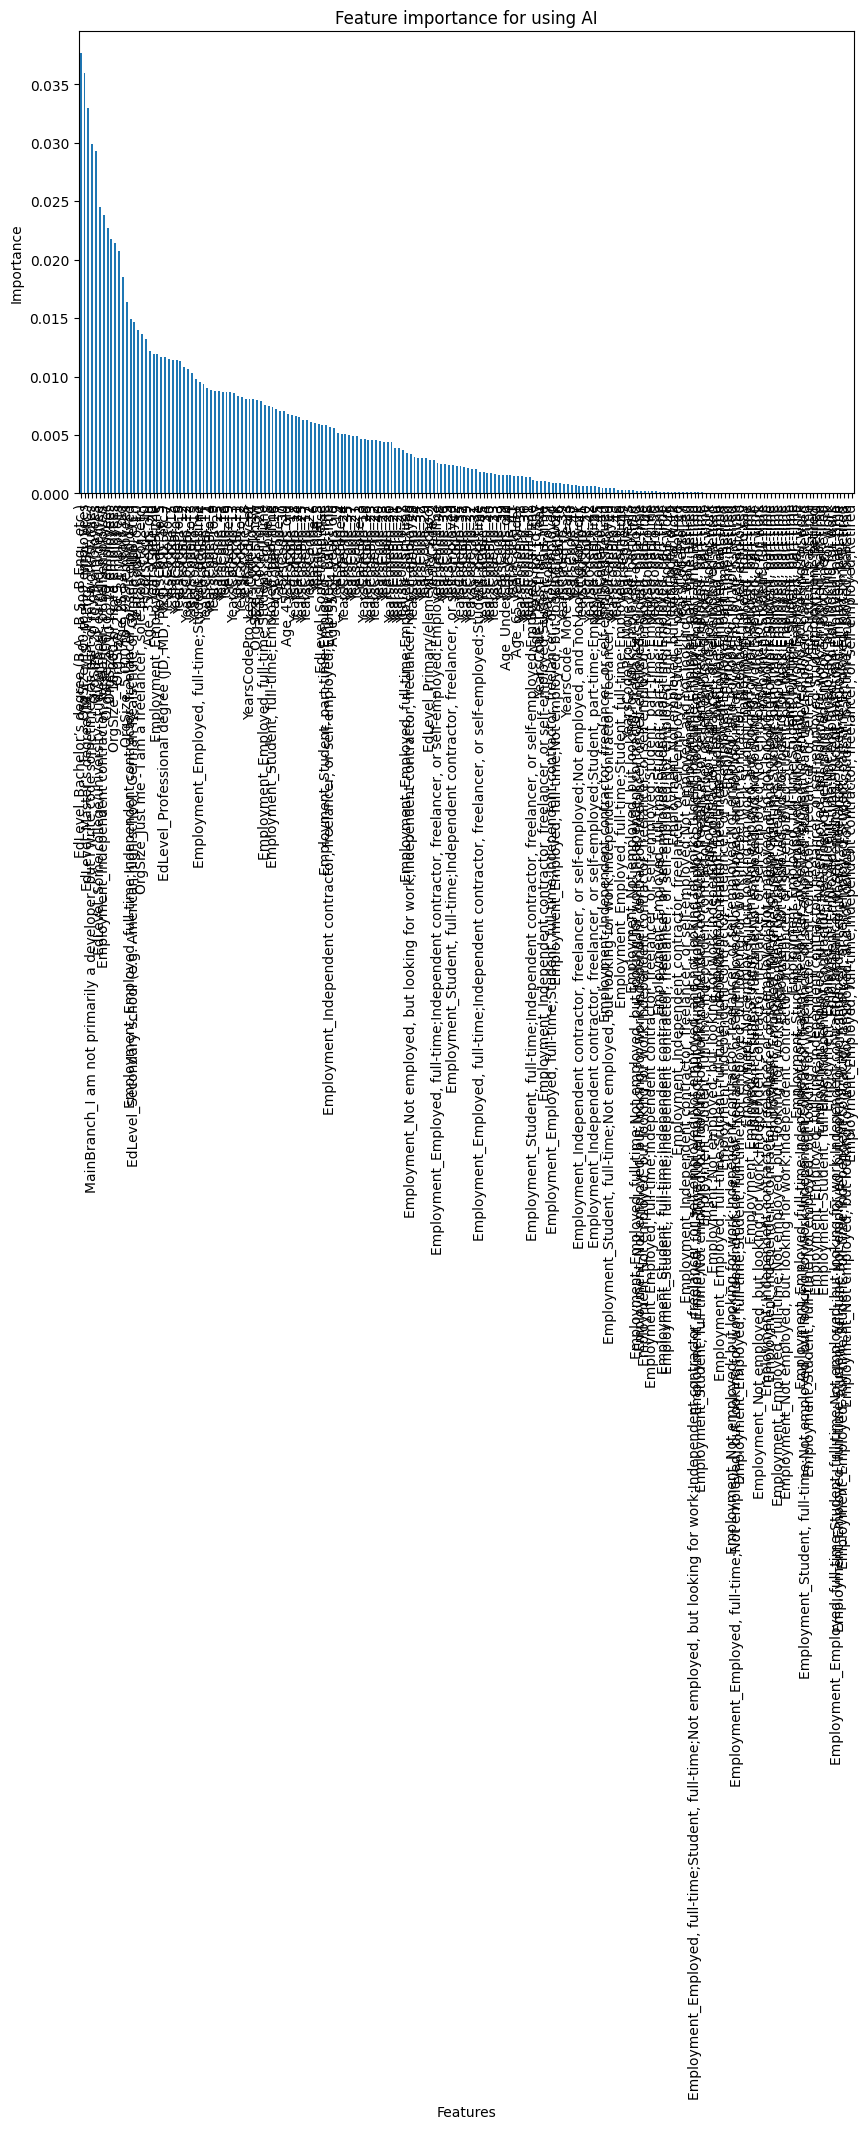

In [8]:
# plot sorted feature list 
plt.figure(figsize=(10,6))
feature_importances.plot(kind="bar")
plt.title("Feature importance for using AI")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [9]:
# sum up all encoded feature importances for one original feature to evaluate the importance of the original feature

original_feature_map = [name.split('_')[0] for name in feature_names]

df_original_feature_importance = pd.DataFrame({
    "original_feature": original_feature_map,
    "importance": importances
})

aggregated_importance = df_original_feature_importance.groupby("original_feature").sum().sort_values(by="importance", ascending=False).reset_index()



# evaluate the current models accurancy
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

from sklearn.metrics import accuracy_score
acc_train = accuracy_score(y_pred_train, y_train)
acc_test = accuracy_score(y_pred_test, y_test)
print(acc_train)
print(acc_test)


0.8453779227841218
0.5608960417572858


In [10]:
df_original_feature_importance.info()
aggregated_importance.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   original_feature  202 non-null    object 
 1   importance        202 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   original_feature  7 non-null      object 
 1   importance        7 non-null      float64
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


<Figure size 1000x600 with 0 Axes>

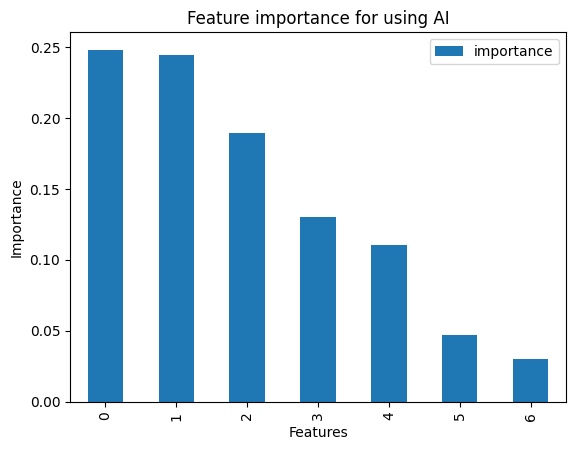

['MainBranch', 'Age', 'Age', 'Age', 'Age', 'Age', 'Age', 'Age', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment', 'Employment'

In [11]:
# plot sorted feature list 
plt.figure(figsize=(10,6))
aggregated_importance.plot(kind="bar")
plt.title("Feature importance for using AI")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()
print(original_feature_map)

In [12]:
print(aggregated_importance["original_feature"])

0       YearsCode
1    YearsCodePro
2         OrgSize
3         EdLevel
4      Employment
5             Age
6      MainBranch
Name: original_feature, dtype: object


In [13]:
# check if a new model with only the four highest features yields a better model accurancy
df_X_refined=df_X.drop(["Employment","Age","MainBranch"],axis=1)
current_encoder_opt=OneHotEncoder(drop="first", sparse_output=False)
X_encoded_opt=current_encoder.fit_transform(df_X_refined)

In [14]:
# to identfy the most important features 
# create train and test data set
X_train_opt,X_test_opt,y_train_opt,y_test_opt=train_test_split(X_encoded_opt,y_encoded,test_size=0.2,random_state=42)

model_opt=RandomForestClassifier(random_state=42)
model_opt.fit(X_train_opt,y_train_opt)

y_pred_train_opt = model_opt.predict(X_train_opt)
y_pred_test_opt = model_opt.predict(X_test_opt)

acc_train_opt = accuracy_score(y_pred_train_opt, y_train_opt)
acc_test_opt = accuracy_score(y_pred_test_opt, y_test_opt)
print(acc_train_opt)
print(acc_test_opt)

0.7475802066340402
0.5678555893866899


In [15]:
# The simplified model yields a similar low accuracy score for the test data as the original one. Thus there is no clear correlation between
